In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.text import *

## Translation files

French/English parallel texts from http://www.statmt.org/wmt15/translation-task.html .  It was created by Chris Callison-Burch, who crawled millions of web pages and then used *a set of simple heuristics to transform French URLs onto English URLs (i.e. replacing "fr" with "en" and about 40 other hand-written rules), and assume that these documents are translations of each other*.

In [3]:
PATH = Path('data/translate')
TMP_PATH = PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)
fname='giga-fren.release2.fixed'
en_fname = PATH/f'{fname}.en'
fr_fname = PATH/f'{fname}.fr'

Only using question texts to limit how long training takes...

In [4]:
re_eq = re.compile('^(Wh[^?.!]+\?)')
re_fq = re.compile('^([^?.!]+\?)')

# lines -> generator object
lines = ((re_eq.search(eq), re_fq.search(fq)) 
         for eq, fq in zip(open(en_fname, encoding='utf-8'), open(fr_fname, encoding='utf-8')))

qs = [(e.group(), f.group()) for e,f in lines if e and f]

In [5]:
qs[:5], len(qs)

([('What is light ?', 'Qu’est-ce que la lumière?'),
  ('Who are we?', 'Où sommes-nous?'),
  ('Where did we come from?', "D'où venons-nous?"),
  ('What would we do without it?', 'Que ferions-nous sans elle ?'),
  ('What is the absolute location (latitude and longitude) of Badger, Newfoundland and Labrador?',
   'Quelle sont les coordonnées (latitude et longitude) de Badger, à Terre-Neuve-etLabrador?')],
 52331)

In [ ]:
pickle.dump(qs, (PATH/'fr-en-qs.pkl').open('wb'))

In [ ]:
qs = pickle.load((PATH/'fr-en-qs.pkl').open('rb'))

In [6]:
en_qs,fr_qs = zip(*qs)

In [7]:
en_tok = Tokenizer.proc_all_mp(partition_by_cores(en_qs))

In [ ]:
# !python -m spacy download fr

In [8]:
fr_tok = Tokenizer.proc_all_mp(partition_by_cores(fr_qs), 'fr')

In [9]:
en_tok[0], fr_tok[0]

(['what', 'is', 'light', '?'],
 ['qu’', 'est', '-ce', 'que', 'la', 'lumière', '?'])

In [ ]:
np.percentile([len(o) for o in en_tok], 96), np.percentile([len(o) for o in fr_tok], 91)

In [10]:
keep = np.array([len(o)<30 for o in en_tok])

In [11]:
len(en_tok), len(fr_tok)

(52331, 52331)

In [12]:
en_tok = np.array(en_tok)[keep]
fr_tok = np.array(fr_tok)[keep]
len(en_tok), len(fr_tok)

(50260, 50260)

In [13]:
pickle.dump(en_tok, (PATH/'en_tok.pkl').open('wb'))
pickle.dump(fr_tok, (PATH/'fr_tok.pkl').open('wb'))

In [ ]:
en_tok = pickle.load((PATH/'en_tok.pkl').open('rb'))
fr_tok = pickle.load((PATH/'fr_tok.pkl').open('rb'))

In [14]:
def toks2ids(tok,pre):
    freq = Counter(p for o in tok for p in o)
    itos = [o for o,c in freq.most_common(40000)]
#     itos.insert(0, '_bos_')
    itos.insert(0, '_unk_')
    itos.insert(1, '_pad_')
#     itos.insert(2, '_eos_')
    
    stoi = collections.defaultdict(lambda: 0, {v:k for k,v in enumerate(itos)})
    ids = np.array([([stoi[o] for o in p]) for p in tok])
    np.save(TMP_PATH/f'{pre}_ids.npy', ids)
    pickle.dump(itos, open(TMP_PATH/f'{pre}_itos.pkl', 'wb'))
    return ids,itos,stoi

In [15]:
en_ids,en_itos,en_stoi = toks2ids(en_tok,'en')
fr_ids,fr_itos,fr_stoi = toks2ids(fr_tok,'fr')

In [4]:
def load_ids(pre):
    ids = np.load(TMP_PATH/f'{pre}_ids.npy')
    itos = pickle.load(open(TMP_PATH/f'{pre}_itos.pkl', 'rb'))
    stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
    return ids,itos,stoi

In [5]:
en_ids,en_itos,en_stoi = load_ids('en')
fr_ids,fr_itos,fr_stoi = load_ids('fr')

In [16]:
[fr_itos[o] for o in fr_ids[0]], len(en_itos), len(fr_itos)

(['qu’', 'est', '-ce', 'que', 'la', 'lumière', '?'], 17571, 24791)

## Word vectors

fasttext word vectors available from https://fasttext.cc/docs/en/english-vectors.html  

Why use word vectors instead of pretrained language models??  Because Jeremy hasn't tried it yet.  Should work better and something to potentially try.

In [ ]:
# ! pip install git+https://github.com/facebookresearch/fastText.git

In [17]:
import fastText as ft

To use the fastText library, you'll need to download [fasttext word vectors](https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md) for your language (download the 'bin plus text' ones).

In [18]:
for lang in ['en', 'fr']:
    fname = f'wiki.{lang}.zip'
    !wget -P {PATH} https://s3-us-west-1.amazonaws.com/fasttext-vectors/{fname}
    !unzip {PATH/fname} -d {PATH}
    print(f'{lang} done')

--2018-06-20 13:38:57--  https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 54.231.237.33
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|54.231.237.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10356881291 (9.6G) [application/zip]
Saving to: ‘data/translate/wiki.en.zip’

wiki.en.zip         100%[===================>]   9.65G  22.2MB/s    in 5m 42s  

2018-06-20 13:44:40 (28.9 MB/s) - ‘data/translate/wiki.en.zip’ saved [10356881291/10356881291]

Archive:  data/translate/wiki.en.zip
  inflating: data/translate/wiki.en.vec  
  inflating: data/translate/wiki.en.bin  
en done
--2018-06-20 13:47:15--  https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.24.25
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.24.25|:443... connected.
HTTP request 

In [19]:
en_vecs = ft.load_model(str((PATH/'wiki.en.bin')))

In [20]:
fr_vecs = ft.load_model(str((PATH/'wiki.fr.bin')))

In [21]:
def get_vecs(lang, ft_vecs):
    vecd = {w:ft_vecs.get_word_vector(w) for w in ft_vecs.get_words()}
    pickle.dump(vecd, open(PATH/f'wiki.{lang}.pkl','wb'))
    return vecd

In [ ]:
# reads file line by line to avoid memory problems and doesn't pickle
def get_vecs_osx(lang):
    vecd = {}
    with open(PATH/f'wiki.{lang}.vec', encoding='utf-8') as infile:
        for line in infile:
            word,*vec = line.split()
            if len(vec) == 300:
                en_vecd[word] = np.array(vec, dtype=np.float32)
    return vecd

In [22]:
en_vecd = get_vecs('en', en_vecs)
fr_vecd = get_vecs('fr', fr_vecs)

# en_vecd = get_vecs_osx('en')
# fr_vecd = get_vecs_osx('fr')

In [7]:
en_vecd = pickle.load(open(PATH/'wiki.en.pkl','rb'))
fr_vecd = pickle.load(open(PATH/'wiki.fr.pkl','rb'))

In [23]:
len(en_vecd), len(fr_vecd)

(2519370, 1152449)

In [ ]:
# ft_words = ft_vecs.get_words(include_freq=True)
# ft_word_dict = {k:v for k,v in zip(*ft_words)}
# ft_words = sorted(ft_word_dict.keys(), key=lambda x: ft_word_dict[x])

# len(ft_words)

In [24]:
dim_en_vec = len(en_vecd[','])
dim_fr_vec = len(fr_vecd[','])
dim_en_vec,dim_fr_vec

(300, 300)

In [25]:
en_vecs = np.stack(list(en_vecd.values()))
en_vecs.mean(),en_vecs.std()

(0.0075652334, 0.29283327)

## Model data

In [27]:
enlen_90 = int(np.percentile([len(o) for o in en_ids], 99))
frlen_90 = int(np.percentile([len(o) for o in fr_ids], 97))
enlen_90,frlen_90

(28, 32)

In [28]:
en_ids_tr = np.array([o[:enlen_90] for o in en_ids])
fr_ids_tr = np.array([o[:frlen_90] for o in fr_ids])

In [29]:
class Seq2SeqDataset(Dataset):
    def __init__(self, x, y): self.x,self.y = x,y
    def __getitem__(self, idx): return A(self.x[idx], self.y[idx])  # A() => ensures arguments are numpy arrays
    def __len__(self): return len(self.x)

In [30]:
# Clever way to seperate out a validation set w/ random numbers

np.random.seed(42)
trn_keep = np.random.rand(len(en_ids_tr))>0.1   # check list of random numbers for greater than .1 => list of bools
en_trn,fr_trn = en_ids_tr[trn_keep],fr_ids_tr[trn_keep]   # index into data set w/ list of bools => training
en_val,fr_val = en_ids_tr[~trn_keep],fr_ids_tr[~trn_keep] # index into data set w/ opposite => validation
len(en_trn),len(en_val)

(45219, 5041)

In [31]:
# translating french to english; reverse them to go the opposite direction
trn_ds = Seq2SeqDataset(fr_trn,en_trn)
val_ds = Seq2SeqDataset(fr_val,en_val)

In [32]:
bs=125

In [33]:
trn_samp = SortishSampler(en_trn, key=lambda x: len(en_trn[x]), bs=bs)
val_samp = SortSampler(en_val, key=lambda x: len(en_val[x]))

In [34]:
# why do we need to transpose?
# already done all of the pre-processing so limit num_workers to 1 to save time
# pad_idx=1 - different length inputs, fastai automatically pads 
# for classifier we want the padding at the start -> final token to represent last word of review
# for a decoder we want the padding at the end
# sampler - sentences of different lengths need to be batched together, use a sampler to save time/memory!!

trn_dl = DataLoader(trn_ds, bs, transpose=True, transpose_y=True, num_workers=1, 
                    pad_idx=1, pre_pad=False, sampler=trn_samp)
val_dl = DataLoader(val_ds, int(bs*1.6), transpose=True, transpose_y=True, num_workers=1, 
                    pad_idx=1, pre_pad=False, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [35]:
it = iter(trn_dl)
its = [next(it) for i in range(5)]
[(len(x),len(y)) for x,y in its]

[(32, 28), (20, 6), (20, 7), (32, 12), (32, 20)]

## Initial model

In [37]:
def create_emb(vecs, itos, em_sz):
    # embeddings: number of rows = vocab size, columns = determined by fasttext word vectors (300)
    emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
    # learnable pytorch module has a 'weight' attribute => Variable
    # 'weight' attribute has a 'data' attribute => Tensor
    wgts = emb.weight.data
    miss = []
    # iterate through vocabulary and replace found words w/ pretrained vector weights if available
    for i,w in enumerate(itos):
        try: wgts[i] = torch.from_numpy(vecs[w]*3)  # *3 => wgts have std_dev of 1; vector has std_dev of .3
        except: miss.append(w)
    print(len(miss),miss[5:10])
    return emb

In [38]:
nh,nl = 256,2

In [39]:
class Seq2SeqRNN(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25)
        self.out_enc = nn.Linear(nh, em_sz_dec, bias=False)
        
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data
        
    def forward(self, inp):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = self.out_enc(h)

        dec_inp = V(torch.zeros(bs).long())  # start off w/ a batch of beginning of stream tokens (0)
        res = []
        # out_sl - output sequence length - length of largest english sentence (output)
        for i in range(self.out_sl):
            # .unsqueeze(0) - add leading unit axis -> treat as a sequence of length 1
            # gru works on an entire sequence at a time but we're iterating through each part separately...
            # not really taking advantage of rnn at all; could re-write using linear layer
            # dec_inp - input to the embedding - previous result
            emb = self.emb_dec(dec_inp).unsqueeze(0)  # embedding
            outp, h = self.gru_dec(emb, h)            # rnn
            outp = self.out(self.out_drop(outp[0]))   # dropout, linear layer
            res.append(outp) # outp -> tensor of length => number of words in english vocab w/ probability for each
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break    # 1: padding token => stop, we're done (padding at the end)
        return torch.stack(res)   # stack up list of results into single tensor and return it
    
    def initHidden(self, bs): return V(torch.zeros(self.nl, bs, self.nh))

In [40]:
# categorical cross entropy loss
# list of probabilities for each word in vocab; target is correct word

def seq2seq_loss(input, target):
    sl,bs = target.size()
    sl_in,bs_in,nc = input.size()
    # tweak 1: we may have stopped early; if seq length is less than target, add some padding
    if sl>sl_in: input = F.pad(input, (0,0,0,0,0,sl-sl_in)) # rank3 tensor requires 6 padding values (before and after)
        # 3rd dimension (sequence length??) add as much padding as necessary at the end
    input = input[:sl]
    # tweak 2: cross_entropy expects rank2 tensor but we have seq_length * bs so we need to flatten out both
    return F.cross_entropy(input.view(-1,nc), target.view(-1))#, ignore_index=1)

In [41]:
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [42]:
rnn = Seq2SeqRNN(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
# SingleModel => way to handle learning rate groups -> treats whole thing as single group
# easy way to turn pytorch module into fastai model
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

3095 ['t_up', 'd’', "qu'", '-ce', 'qu’']
1283 ["n't", 'n’t', ':', '1', '2006']


 75%|███████▌  | 272/362 [00:29<00:09,  9.07it/s, loss=33.7]

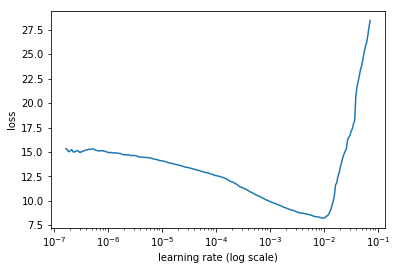

In [44]:
learn.lr_find(start_lr=1e-7)
learn.sched.plot()

In [45]:
lr=1e-3

In [46]:
learn.fit(lr, 1, cycle_len=11, use_clr=(20,10))

epoch      trn_loss   val_loss                              
    0      5.965458   6.010027  
    1      4.604166   4.892848                              
    2      4.088986   4.278022                              
    3      3.828717   3.993507                              
    4      3.703301   3.883787                              
    5      3.351877   3.777268                              
    6      3.324167   3.724023                              
    7      3.357103   3.669032                              
    8      3.469063   3.687872                              
    9      3.105404   3.642561                              
    10     3.144482   3.605386                              


[3.6053855804620434]

In [49]:
learn.fit(lr, 1, cycle_len=3, use_clr=(8,3))

epoch      trn_loss   val_loss                              
    0      3.312397   3.654379  
    1      3.145095   3.622669                              
    2      3.087453   3.549286                              


[3.5492862527556324]

In [50]:
learn.save('initial')

In [ ]:
learn.load('initial')

### Test

In [51]:
x,y = next(iter(val_dl))
probs = learn.model(V(x))
preds = to_np(probs.max(2)[1])

for i in range(180,190):
    print(' '.join([fr_itos[o] for o in x[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in y[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in preds[:,i] if o!=1]))
    print()

quelles composantes des différents aspects de la performance devraient être mesurées , quelles données pertinentes recueillir et comment ?
which components within various performance areas should be measured , whatkinds of data are appropriate to collect , and how should this be done ?
what aspects of the and and and and be be be be be ? ? ?

le premier ministre doit - il nommer un ministre d’ état à la santé mentale , à la maladie mentale et à la toxicomanie ?
what role can the federal government play to ensure that individuals with mental illness and addiction have access to the drug therapy they need ?
who is the minister minister minister of , mental mental mental and mental health

quelles sont les conséquences de la hausse des formes d’ emploi non conformes aux normes chez les travailleurs hautement qualifiés et chez ceux qui occupent des emplois plus marginaux ?
what is the impact of growing forms of non - standard employment for highly skilled workers and for those employed in 

## Bidir

In [ ]:
class Seq2SeqRNN_Bidir(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25, bidirectional=True)
        self.out_enc = nn.Linear(nh*2, em_sz_dec, bias=False)
        self.drop_enc = nn.Dropout(0.05)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data
        
    def forward(self, inp):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = h.view(2,2,bs,-1).permute(0,2,1,3).contiguous().view(2,bs,-1)
        h = self.out_enc(self.drop_enc(h))

        dec_inp = V(torch.zeros(bs).long())
        res = []
        for i in range(self.out_sl):
            emb = self.emb_dec(dec_inp).unsqueeze(0)
            outp, h = self.gru_dec(emb, h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
        return torch.stack(res)
    
    def initHidden(self, bs): return V(torch.zeros(self.nl*2, bs, self.nh))

In [ ]:
rnn = Seq2SeqRNN_Bidir(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

In [ ]:
learn.fit(lr, 1, cycle_len=12, use_clr=(20,10))

In [ ]:
learn.save('bidir')

## Teacher forcing

In [ ]:
class Seq2SeqStepper(Stepper):
    def step(self, xs, y, epoch):
        self.m.pr_force = (10-epoch)*0.1 if epoch<10 else 0
        xtra = []
        output = self.m(*xs, y)
        if isinstance(output,tuple): output,*xtra = output
        self.opt.zero_grad()
        loss = raw_loss = self.crit(output, y)
        if self.reg_fn: loss = self.reg_fn(output, xtra, raw_loss)
        loss.backward()
        if self.clip:   # Gradient clipping
            nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)
        self.opt.step()
        return raw_loss.data[0]

In [ ]:
class Seq2SeqRNN_TeacherForcing(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25)
        self.out_enc = nn.Linear(nh, em_sz_dec, bias=False)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data
        self.pr_force = 1.
        
    def forward(self, inp, y=None):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = self.out_enc(h)

        dec_inp = V(torch.zeros(bs).long())
        res = []
        for i in range(self.out_sl):
            emb = self.emb_dec(dec_inp).unsqueeze(0)
            outp, h = self.gru_dec(emb, h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
            if (y is not None) and (random.random()<self.pr_force):
                if i>=len(y): break
                dec_inp = y[i]
        return torch.stack(res)
    
    def initHidden(self, bs): return V(torch.zeros(self.nl, bs, self.nh))

In [ ]:
rnn = Seq2SeqRNN_TeacherForcing(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

In [ ]:
learn.fit(lr, 1, cycle_len=12, use_clr=(20,10), stepper=Seq2SeqStepper)

In [ ]:
learn.save('forcing')

## Attentional model

In [ ]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

In [ ]:
class Seq2SeqAttnRNN(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25)
        self.out_enc = nn.Linear(nh, em_sz_dec, bias=False)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data

        self.W1 = rand_p(nh, em_sz_dec)
        self.l2 = nn.Linear(em_sz_dec, em_sz_dec)
        self.l3 = nn.Linear(em_sz_dec+nh, em_sz_dec)
        self.V = rand_p(em_sz_dec)

    def forward(self, inp, y=None, ret_attn=False):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = self.out_enc(h)

        dec_inp = V(torch.zeros(bs).long())
        res,attns = [],[]
        w1e = enc_out @ self.W1
        for i in range(self.out_sl):
            w2h = self.l2(h[-1])
            u = F.tanh(w1e + w2h)
            a = F.softmax(u @ self.V, 0)
            attns.append(a)
            Xa = (a.unsqueeze(2) * enc_out).sum(0)
            emb = self.emb_dec(dec_inp)
            wgt_enc = self.l3(torch.cat([emb, Xa], 1))
            
            outp, h = self.gru_dec(wgt_enc.unsqueeze(0), h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
            if (y is not None) and (random.random()<self.pr_force):
                if i>=len(y): break
                dec_inp = y[i]

        res = torch.stack(res)
        if ret_attn: res = res,torch.stack(attns)
        return res

    def initHidden(self, bs): return V(torch.zeros(self.nl, bs, self.nh))

In [ ]:
rnn = Seq2SeqAttnRNN(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

In [ ]:
lr=2e-3

In [ ]:
learn.fit(lr, 1, cycle_len=15, use_clr=(20,10), stepper=Seq2SeqStepper)

In [ ]:
learn.save('attn')

In [ ]:
learn.load('attn')

### Test

In [ ]:
x,y = next(iter(val_dl))
probs,attns = learn.model(V(x),ret_attn=True)
preds = to_np(probs.max(2)[1])

In [ ]:
for i in range(180,190):
    print(' '.join([fr_itos[o] for o in x[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in y[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in preds[:,i] if o!=1]))
    print()

In [ ]:
attn = to_np(attns[...,180])

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
for i,ax in enumerate(axes.flat):
    ax.plot(attn[i])

## All

In [ ]:
class Seq2SeqRNN_All(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25, bidirectional=True)
        self.out_enc = nn.Linear(nh*2, em_sz_dec, bias=False)
        self.drop_enc = nn.Dropout(0.25)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data

        self.W1 = rand_p(nh*2, em_sz_dec)
        self.l2 = nn.Linear(em_sz_dec, em_sz_dec)
        self.l3 = nn.Linear(em_sz_dec+nh*2, em_sz_dec)
        self.V = rand_p(em_sz_dec)

    def forward(self, inp, y=None):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = h.view(2,2,bs,-1).permute(0,2,1,3).contiguous().view(2,bs,-1)
        h = self.out_enc(self.drop_enc(h))

        dec_inp = V(torch.zeros(bs).long())
        res,attns = [],[]
        w1e = enc_out @ self.W1
        for i in range(self.out_sl):
            w2h = self.l2(h[-1])
            u = F.tanh(w1e + w2h)
            a = F.softmax(u @ self.V, 0)
            attns.append(a)
            Xa = (a.unsqueeze(2) * enc_out).sum(0)
            emb = self.emb_dec(dec_inp)
            wgt_enc = self.l3(torch.cat([emb, Xa], 1))
            
            outp, h = self.gru_dec(wgt_enc.unsqueeze(0), h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
            if (y is not None) and (random.random()<self.pr_force):
                if i>=len(y): break
                dec_inp = y[i]
        return torch.stack(res)

    def initHidden(self, bs): return V(torch.zeros(self.nl*2, bs, self.nh))

In [ ]:
rnn = Seq2SeqRNN_All(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

In [ ]:
learn.fit(lr, 1, cycle_len=15, use_clr=(20,10), stepper=Seq2SeqStepper)

### Test

In [ ]:
x,y = next(iter(val_dl))
probs = learn.model(V(x))
preds = to_np(probs.max(2)[1])

for i in range(180,190):
    print(' '.join([fr_itos[o] for o in x[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in y[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in preds[:,i] if o!=1]))
    print()